In [1]:
#データセットの準備
from chainer.datasets import mnist

# データセットがダウンロード済みでなければ、ダウンロードも行う
train_val, test = mnist.get_mnist(withlabel=True, ndim=1)

In [2]:
#validation用のデータセットを作る
from chainer.datasets import split_dataset_random

train, valid = split_dataset_random(train_val, 50000, seed=0)

In [3]:
print('Training dataset size:', len(train))
print('Validation dataset size:', len(valid))

Training dataset size: 50000
Validation dataset size: 10000


In [4]:
#Iteratorの作成
#バッチサイズ分データとラベルを束ねるため

from chainer import iterators

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(
    valid, batchsize, repeat=False, shuffle=False)
test_iter = iterators.SerialIterator(
    test, batchsize, repeat=False, shuffle=False)

In [5]:
import random
import numpy
import chainer

def reset_seed(seed=0):
    random.seed(seed)
    numpy.random.seed(seed)
    if chainer.cuda.available:
        chainer.cuda.cupy.random.seed(seed)

reset_seed(0)

In [6]:
#ネットワークの定義
#Linkはパラメータを持つ関数
#Functionはパラメータを持たない関数
#全てのパラメータをChainにまとめている
#パラメータの更新はOptimizer

import chainer
import chainer.links as L
import chainer.functions as F

class MLP(chainer.Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()

        # パラメータを持つ層の登録
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(n_mid_units, n_mid_units)
            self.l3 = L.Linear(n_mid_units, n_out)

    def __call__(self, x):
        # データを受け取った際のforward計算を書く
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)


gpu_id = 0  # CPUを用いる場合は、この値を-1にしてください

net = MLP()

if gpu_id >= 0:
    net.to_gpu(gpu_id)

In [7]:
print('1つ目の全結合層のバイアスパラメータの形は、', net.l1.b.shape)
print('初期化直後のその値は、', net.l1.b.array)

1つ目の全結合層のバイアスパラメータの形は、 (100,)
初期化直後のその値は、 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [8]:
#最適化手法の定義

from chainer import optimizers

optimizer = optimizers.SGD(lr=0.01).setup(net)

In [9]:
#学習ループのコード

import numpy as np
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu

max_epoch = 10

while train_iter.epoch < max_epoch:

    # ---------- 学習の1イテレーション ----------
    train_batch = train_iter.next()
    x, t = concat_examples(train_batch, gpu_id)

    # 予測値の計算
    y = net(x)

    # ロスの計算
    loss = F.softmax_cross_entropy(y, t)

    # 勾配の計算
    net.cleargrads()
    loss.backward()

    # パラメータの更新
    optimizer.update()
    # --------------- ここまで ----------------

    # 1エポック終了ごとにValidationデータに対する予測精度を測って、
    # モデルの汎化性能が向上していることをチェックしよう
    if train_iter.is_new_epoch:  # 1 epochが終わったら

        # ロスの表示
        print('epoch:{:02d} train_loss:{:.04f} '.format(
            train_iter.epoch, float(to_cpu(loss.data))), end='')

        valid_losses = []
        valid_accuracies = []
        while True:
            valid_batch = valid_iter.next()
            x_valid, t_valid = concat_examples(valid_batch, gpu_id)

            # Validationデータをforward
            with chainer.using_config('train', False), \
                    chainer.using_config('enable_backprop', False):
                y_valid = net(x_valid)

            # ロスを計算
            loss_valid = F.softmax_cross_entropy(y_valid, t_valid)
            valid_losses.append(to_cpu(loss_valid.array))

            # 精度を計算
            accuracy = F.accuracy(y_valid, t_valid)
            accuracy.to_cpu()
            valid_accuracies.append(accuracy.array)

            if valid_iter.is_new_epoch:
                valid_iter.reset()
                break

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
            np.mean(valid_losses), np.mean(valid_accuracies)))

# テストデータでの評価
test_accuracies = []
while True:
    test_batch = test_iter.next()
    x_test, t_test = concat_examples(test_batch, gpu_id)

    # テストデータをforward
    with chainer.using_config('train', False), \
            chainer.using_config('enable_backprop', False):
        y_test = net(x_test)

    # 精度を計算
    accuracy = F.accuracy(y_test, t_test)
    accuracy.to_cpu()
    test_accuracies.append(accuracy.array)

    if test_iter.is_new_epoch:
        test_iter.reset()
        break

print('test_accuracy:{:.04f}'.format(np.mean(test_accuracies)))

epoch:01 train_loss:0.8898 val_loss:0.9713 val_accuracy:0.7921
epoch:02 train_loss:0.5384 val_loss:0.5326 val_accuracy:0.8642
epoch:03 train_loss:0.4002 val_loss:0.4227 val_accuracy:0.8848
epoch:04 train_loss:0.3321 val_loss:0.3741 val_accuracy:0.8941
epoch:05 train_loss:0.4601 val_loss:0.3456 val_accuracy:0.9002
epoch:06 train_loss:0.2484 val_loss:0.3275 val_accuracy:0.9074
epoch:07 train_loss:0.3312 val_loss:0.3111 val_accuracy:0.9119
epoch:08 train_loss:0.3799 val_loss:0.2992 val_accuracy:0.9146
epoch:09 train_loss:0.2995 val_loss:0.2888 val_accuracy:0.9173
epoch:10 train_loss:0.3228 val_loss:0.2806 val_accuracy:0.9198
test_accuracy:0.9230


In [10]:
#学習済みモデルを保存する


from chainer import serializers

serializers.save_npz('my_mnist.model', net)

In [11]:
#保存したモデルを読み込んで推論する

# まず同じネットワークのオブジェクトを作る
infer_net = MLP()

# そのオブジェクトに保存済みパラメータをロードする
serializers.load_npz('my_mnist.model', infer_net)

(784,)


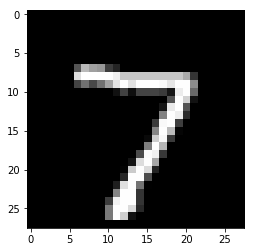

元の形： (784,) -> ミニバッチの形にしたあと： (1, 784)
ネットワークの予測: 7


In [14]:
#保存済みモデルを用いたテストデータの分類
from matplotlib import pyplot as plt

gpu_id = 0  # CPUで計算をしたい場合は、-1を指定してください

if gpu_id >= 0:
    infer_net.to_gpu(gpu_id)

# 1つ目のテストデータを取り出します
x, t = test[0]  #  tは使わない

print(x.shape)
# どんな画像か表示してみます
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()

# ミニバッチの形にする（複数の画像をまとめて推論に使いたい場合は、サイズnのミニバッチにしてまとめればよい）
print('元の形：', x.shape, end=' -> ')

#
x = x[None, ...]

print('ミニバッチの形にしたあと：', x.shape)

# ネットワークと同じデバイス上にデータを送る
x = infer_net.xp.asarray(x)

# モデルのforward関数に渡す
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y = infer_net(x)

# Variable形式で出てくるので中身を取り出す
y = y.array

# 結果をCPUに送る
y = to_cpu(y)

# 予測確率の最大値のインデックスを見る
pred_label = y.argmax(axis=1)

print('ネットワークの予測:', pred_label[0])

In [15]:
#Trainer:学習ループ書く必要なくなる

#データセット・Iterator・ネットワークの準備
reset_seed(0)

train_val, test = mnist.get_mnist()
train, valid = split_dataset_random(train_val, 50000, seed=0)

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(valid, batchsize, False, False)
test_iter = iterators.SerialIterator(test, batchsize, False, False)

gpu_id = 0  # CPUを用いたい場合は、-1を指定してください

net = MLP()

if gpu_id >= 0:
    net.to_gpu(gpu_id)
    

In [16]:
#Updatorの準備
from chainer import training

gpu_id = 0  # CPUを使いたい場合は-1を指定してください

# ネットワークをClassifierで包んで、ロスの計算などをモデルに含める
net = L.Classifier(net)

# 最適化手法の選択
optimizer = optimizers.SGD(lr=0.01).setup(net)

# UpdaterにIteratorとOptimizerを渡す
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

In [18]:
#Trainerの準備

max_epoch = 10

# TrainerにUpdaterを渡す
trainer = training.Trainer(
    updater, (max_epoch, 'epoch'), out='mnist_result')

#TrainerにExtentionを追加する
Trainer利点
・ログを自動的にファイルに保存（LogReport)
・ターミナルに定期的にロスなどの情報を表示（PrintReport）
・ロスを定期的にグラフで可視化して画像として保存（PlotReport)
・定期的にモデルやOptimizerの状態を自動シリアライズ（snapshot）
・学習の進捗を示すプログレスバーを表示（ProgressBar）
・ネットワークの構造をGraphvizのdot形式で保存（dump_graph）
・ネットワークのパラメータの平均や分散などの統計情報を出力（ParameterStatistics）


In [19]:
from chainer.training import extensions

trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(valid_iter, net, device=gpu_id), name='val')
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'l1/W/data/std', 'elapsed_time']))
trainer.extend(extensions.ParameterStatistics(net.predictor.l1, {'std': np.std}))
trainer.extend(extensions.PlotReport(['l1/W/data/std'], x_key='epoch', file_name='std.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))


In [20]:
trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  l1/W/data/std  elapsed_time
1           1.66917     0.599904       0.938911       0.806764           0.0359232      3.31191       
2           0.673338    0.84323        0.519284       0.86699            0.0366054      5.94183       
3           0.459914    0.878706       0.414859       0.887757           0.0370351      8.44109       
4           0.38953     0.893262       0.370484       0.896855           0.037301       10.9553       
5           0.353165    0.901215       0.342334       0.90447            0.03749        13.419        
6           0.330145    0.90609        0.322123       0.90981            0.0376389      15.9496       
7           0.312333    0.910886       0.306795       0.913172           0.0377671      18.4351       
8           0.298131    0.914724       0.295106       0.915941           0.0378811      20.9031       
9           0.285828    0.917639       0.284152       0.918513           0.

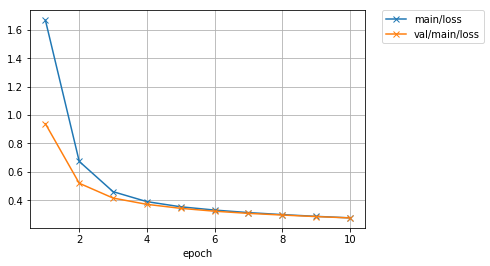

In [21]:
from IPython.display import Image
Image(filename='mnist_result/loss.png')

In [22]:
#テストデータで評価する
test_evaluator = extensions.Evaluator(test_iter, net, device=gpu_id)
results = test_evaluator()
print('Test accuracy:', results['main/accuracy'])

Test accuracy: 0.9250395


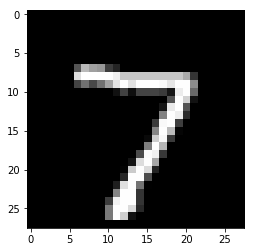

予測ラベル: 7


In [23]:
#学習済みモデルで推論する
reset_seed(0)

infer_net = MLP()
serializers.load_npz(
    'mnist_result/snapshot_epoch-10',
    infer_net, path='updater/model:main/predictor/')

if gpu_id >= 0:
    infer_net.to_gpu(gpu_id)

x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()

x = infer_net.xp.asarray(x[None, ...])
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y = infer_net(x)
y = to_cpu(y.array)

print('予測ラベル:', y.argmax(axis=1)[0])